<a href="https://colab.research.google.com/github/mathster101/CatsVDogs/blob/master/CatsVsDogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import time as t
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from random import randint
import numpy as np
import tqdm
from matplotlib import pyplot as plt


from_file = np.load('/content/drive/My Drive/python/cvd.npy',allow_pickle=True)

In [0]:
data = []
for f in from_file:
   entry = []
   img = f[0]/255
   tar = f[1]
   img_t = torch.Tensor([img])
   entry.append(img_t)
   entry.append(tar)
   #entry = tuple(entry)
   #print(entry)
   data.append(entry)

In [0]:
trainset = torch.utils.data.DataLoader(data[400:], batch_size = 64,
                                       shuffle = True)
testset = torch.utils.data.DataLoader(data[:400], batch_size = 1,
                                       shuffle = True)

In [0]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 50, kernel_size=3)
        self.conv2 = nn.Conv2d(50, 50, kernel_size=3)
        self.conv3 = nn.Conv2d(50, 60, kernel_size=3)
        self.conv4 = nn.Conv2d(60, 75, kernel_size=3)
        self.conv5 = nn.Conv2d(75, 200, kernel_size=3)
        self.conv6 = nn.Conv2d(200, 400, kernel_size=3)
        self.mp = nn.MaxPool2d(2)
        self.fc = nn.Linear(6400, 20)
        self.op = nn.Linear(20,2)
        self.bn1 = nn.BatchNorm2d(50)
        self.bn2 = nn.BatchNorm2d(200)
        

    def forward(self, x):
        in_size = x.size(0)
        x = self.bn1(self.mp(self.conv1(x).relu()))
        x = self.conv2(x)
        x = self.mp(self.conv3(x).relu())
        x = self.conv4(x).relu()
        x = self.bn2(self.conv5(x).relu())
        x = self.conv6(x).relu()
        x = x.view(in_size, -1)  # flatten the tensor
        x = self.fc(x).relu()
        x = self.op(x)
        return x
     
class Net2(nn.Module):

    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 50, kernel_size=3)
        self.conv2 = nn.Conv2d(50, 50, kernel_size=3)
        self.conv3 = nn.Conv2d(50, 60, kernel_size=3)
        self.conv4 = nn.Conv2d(60, 75, kernel_size=3)
        self.conv5 = nn.Conv2d(75, 200, kernel_size=3)
        self.conv6 = nn.Conv2d(200, 400, kernel_size=3)
        self.conv7 = nn.Conv2d(400,600,2)
        self.mp = nn.MaxPool2d(2)
        self.fc = nn.Linear(5400, 200)
        self.op = nn.Linear(200,2)
        self.bn1 = nn.BatchNorm2d(50)
        self.bn2 = nn.BatchNorm2d(200)        

    def forward(self, x):
        in_size = x.size(0)
        x = self.bn1(self.mp(self.conv1(x).relu()))
        x = F.relu(self.conv2(x))
        x = F.relu(self.mp(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = self.bn2(self.conv5(x).relu())
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))  
        x = x.view(in_size, -1)  # flatten the tensor
        x = self.fc(x).relu()
        x = self.op(x)
        return x
loss_func = nn.CrossEntropyLoss()
net = Net2().cuda()

print('net created')
optimizer = optim.Adam(net.parameters(), lr=(1.0e-3))

net created


In [0]:
def test():
   #testing time
   net.eval()
   total = 0
   correct = 0
   
   #print('validation ongoing')
   
   for dat in testset:
      x,y = dat
      x = x.cuda()
      output = net(x)
      y = list(y)
      values, indices = output[0].max(0)
      y = int(y[0])
      indices = int(indices)
   #   print('True Value = ',y)
   #   print('Prediction = ',indices)
   #   print('\n______________________________________')
      if y == indices:
         correct += 1
   
         
      total += 1
   #print((correct/total)*100,'validation accuracy')
   return (correct/total)
acc = []
losses = []

In [0]:
count = 0
for epoch in tqdm.tqdm(range(15)):
   net.train()#training mode
   for data in trainset:
      t1 = t.time()
      x,y = data
      x = x.cuda()
      y = y.cuda()
      optimizer.zero_grad()
      output = net(x)
      #print(output,y)
      loss = loss_func(output, y)
      #print(output,y)
      loss.backward()
      optimizer.step()
      
      count  += 1
      if count%5 == 0:
         #print(round(float(loss),4),'|||',round((t.time() - t1)*1000,3),'ms/batch    ',epoch)
         count  = 0
         losses.append(float(loss))
   acc.append(test())

100%|██████████| 15/15 [01:56<00:00,  7.76s/it]


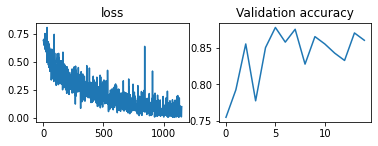

0.8775

In [0]:
fig = plt.figure()
plt.subplot(222)
plt.plot(acc)
plt.title('Validation accuracy')
plt.subplot(221)
plt.plot(losses)
plt.title('loss')
plt.show()
max(acc)